References:
1. [Topic Modelling & LDA](https://www.baeldung.com/cs/latent-dirichlet-allocation)
2. [Coherence Score](https://www.baeldung.com/cs/topic-modeling-coherence-score)
3. [NMF for Topic Modelling Tutorial](https://towardsdatascience.com/topic-modeling-articles-with-nmf-8c6b2a227a45) 

# **Imports**

In [ ]:
!pip install matplotlib==3.5.2 --quiet
!pip install matplotlib_inline --quiet
!pip install spacy --quiet

     |████████████████████████████████| 11.2 MB 4.6 MB/s 
     |████████████████████████████████| 956 kB 50.0 MB/s 


In [ ]:
!python -m spacy download en_core_web_sm

2022-08-24 13:16:19.161738: E tensorflow/stream_executor/cuda/cuda_driver.cc:271] failed call to cuInit: CUDA_ERROR_NO_DEVICE: no CUDA-capable device is detected
Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/
     |████████████████████████████████| 12.8 MB 5.4 MB/s 
✔ Download and installation successful
You can now load the package via spacy.load('en_core_web_sm')


In [ ]:
# General
import pandas as pd
import numpy as np
import sklearn
import pickle

# Text preprocessing
import spacy
from nltk.corpus import treebank
import nltk 
import string
import re

# image
from PIL import Image

# Plotting
import matplotlib.pyplot as plt
import seaborn as sb

sb.set_style('darkgrid')
%matplotlib inline

# save img in svg format
from matplotlib_inline.backend_inline import set_matplotlib_formats
set_matplotlib_formats('svg')

# google 
from google.colab import drive
drive.mount("/content/gdrive")

# Display data frame as a table
from google.colab import data_table
#data_table.enable_dataframe_formatter()

# Suppress warnings
import warnings

warnings.filterwarnings("ignore")

# pretty print
from pprint import pprint

Drive already mounted at /content/gdrive; to attempt to forcibly remount, call drive.mount("/content/gdrive", force_remount=True).


In [ ]:
nltk.download('stopwords')

[nltk_data] Downloading package stopwords to /root/nltk_data...
[nltk_data]   Unzipping corpora/stopwords.zip.


True

# **1) Preprocessing**
To do:

1. Convert missing abstract fields to None.
2. Remove punctuation.
3. Lowercase everything

In [19]:
path = "bbc_articles.csv"

df = pd.read_csv(path)
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 2225 entries, 0 to 2224
Data columns (total 3 columns):
 #   Column    Non-Null Count  Dtype 
---  ------    --------------  ----- 
 0   Category  2225 non-null   object
 1   Heading   2225 non-null   object
 2   Article   2225 non-null   object
dtypes: object(3)
memory usage: 52.3+ KB


In [20]:
punc = string.punctuation + "\\n"
punc

'!"#$%&\'()*+,-./:;<=>?@[\\]^_`{|}~\\n'

In [21]:
# load the spacy model
spacy_model = spacy.load('en_core_web_sm', disable = ['parser', 'ner'])

In [22]:
# 1) Drop punctuation.
# 2) Lowercase text
# 3) Drop numbers
# 4) Apply lemmatization to convert the different inflectional forms of a word to its base form.
df["text_processed"] = df["Article"].apply(lambda x: re.sub(f"[{punc}0-9]", "", x.strip().lower()))
df["text_processed"] = df["text_processed"].apply(lambda x: " ".join([token.lemma_ for token in spacy_model(x)]))

df.head(7)

,Category,Heading,Article,text_processed
0,business,US consumer confidence up,Consumers' confidence in the state of the US ...,consumer confidence in the state of the us eco...
1,business,The 'ticking budget' facing the US,The budget proposals laid out by the administ...,the budget proposal lay out by the administrat...
2,business,Mitsubishi in Peugeot link talks,Trouble-hit Mitsubishi Motors is in talks wit...,troublehit mitsubishi motors be in talk with f...
3,business,BMW reveals new models pipeline,BMW is preparing to enter the market for car-...,bmw be prepare to enter the market for carstyl...
4,business,World leaders gather to face uncertainty,"More than 2,000 business and political leader...",more than business and political leader from...
5,business,Madagascar completes currency switch,Madagascar has completed the replacement of i...,madagascar have complete the replacement of it...
6,business,Troubled Marsh under SEC scrutiny,The US stock market regulator is investigatin...,the us stock market regulator be investigate t...


## **I. Most Frequently Occuring words**

In [23]:
# Long string of every article
long_string = [item.split(' ') for item in list(df["text_processed"])]
long_string = [item.strip() for sublist in long_string for item in sublist]

In [24]:
# Counter object
from collections import Counter

word_counts = pd.DataFrame.from_dict(Counter(long_string), 
                                     orient = 'index',).reset_index()

word_counts.columns = ["words", "frequencies"]                                     
word_counts = word_counts.sort_values("frequencies", ascending = False).reset_index(drop = True)

# drop that one row with ""
word_counts = word_counts.loc[word_counts["words"] != '']

top_counts = word_counts.head(25)

word_counts


,words,frequencies
0,the,52541
2,be,30878
3,to,24669
4,of,19889
5,and,18536
...,...,...
25325,jacqui,1
25326,arranger,1
25327,paternity,1
25328,pickett,1


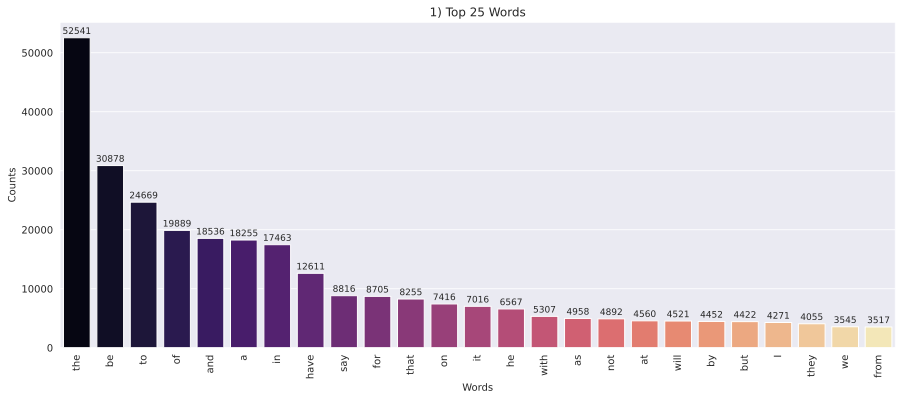

In [25]:
# Word Frequency Barplot
plt.figure(figsize = (15, 6))

# f = pd.DataFrame({"tops": long_string})

ax = sb.barplot(top_counts["words"], 
                top_counts["frequencies"],
                palette = "magma",
                order = top_counts["words"])

ax.bar_label(ax.containers[0], fontsize = 9, padding = 2)

plt.xlabel("Words") #, fontsize = 12)
plt.ylabel("Counts") #, fontsize = 12)
plt.title("1) Top 25 Words") #, fontsize = 16)

plt.xticks(rotation = 90)#, fontsize = 10)
#plt.yticks(fontsize = 10)

plt.show()


## **II. Word Cloud**

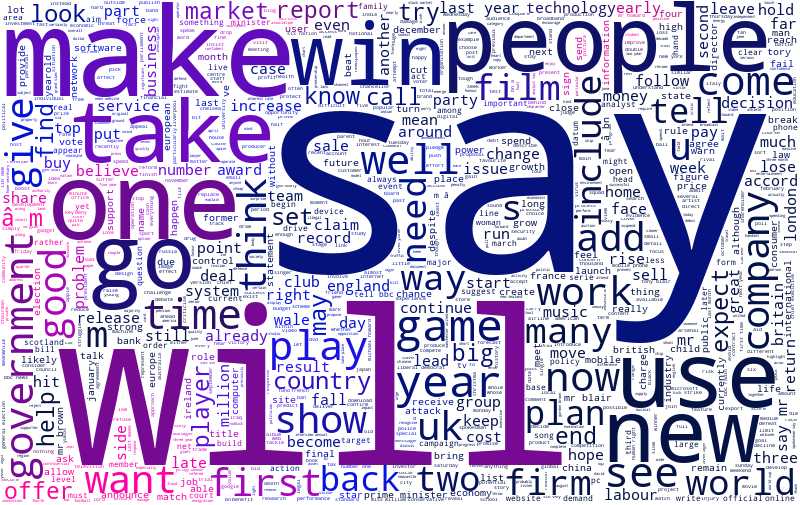

In [26]:
from wordcloud import WordCloud, ImageColorGenerator

long_string = ",".join(list(df["text_processed"]))

# creating a color mask
p3 = "wc2.webp"
mask_colouring = np.array(Image.open(p3))

# create coloring from image
image_colors = ImageColorGenerator(mask_colouring)

# wc object
wc = WordCloud(background_color = "white",   
               height = 505,
               width = 800,   
               max_words = 1000,
               color_func = image_colors)

# make word cloud
wc.generate(long_string)

# display wc
wc.to_image()

# **2) Removing Extra Stopwords**

In [27]:
# remove stopwords
from nltk.corpus import stopwords

stop_words = stopwords.words("english")
stop_words.extend(["said", "would", "mr", "people", "also"])

# Also drop the 75 most commonly appearing words as they are stopwords too.
stop_words.extend(list(top_counts["words"][:85]))

# convert sentences to a list of tokens & remove stopwords
from gensim.utils import simple_preprocess

# remove stopwords
def clean_sentences(sentence: str):
  return " ".join([word for word in simple_preprocess(str(sentence), deacc = True) if not word in stop_words])

df["text_processed"] = df["text_processed"].apply(lambda x: clean_sentences(x))

# ----------------  This part should also be in the main notebook -------------
# split up sentences into tokens
def sent_2_tokens(sentences: list):
  for sentence in sentences:
    yield sentence.split(' ')

# list of sentences
data = list(df["text_processed"])
data_words = list(sent_2_tokens(data))

print(data_words[2][:10])

['troublehit', 'mitsubishi', 'motors', 'talk', 'french', 'carmaker', 'psa', 'peugeot', 'citroen', 'possible']


In [28]:
# Top 20 words after stopword removal
long_string = [item for sublist in data_words for item in sublist]

word_counts = pd.DataFrame.from_dict(Counter(long_string), 
                                     orient = 'index',).reset_index()

word_counts.columns = ["words", "frequencies"]                                     
word_counts = word_counts.sort_values("frequencies", ascending = False).reset_index(drop = True)

# drop that one row with ""
word_counts = word_counts.loc[word_counts["words"] != '']

top_counts = word_counts.head(100)
top_counts

,words,frequencies
0,year,2841
1,make,2192
2,new,1918
3,one,1798
4,take,1709
...,...,...
95,put,566
96,public,554
97,system,548
98,share,547


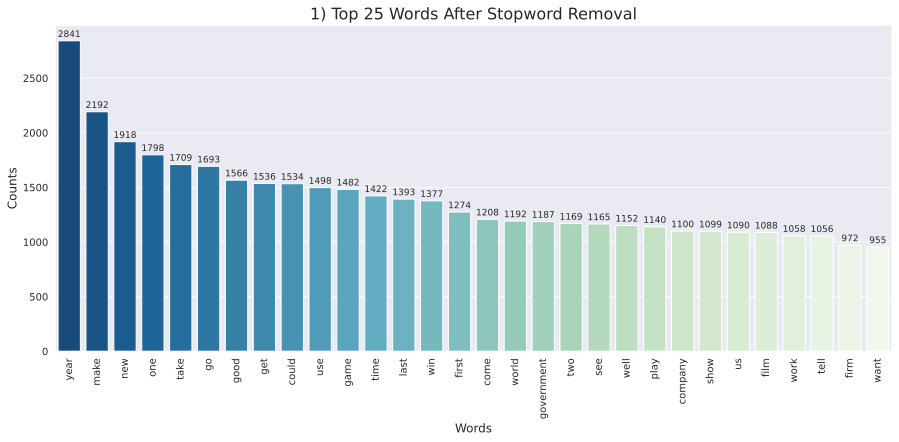

In [29]:
# Word Frequency Barplot
plt.figure(figsize = (15, 6))

f = pd.DataFrame({"words": long_string})

ax = sb.barplot(top_counts["words"][:30], 
                top_counts["frequencies"],
                palette = "GnBu_r",
                order = top_counts["words"][:30])

ax.bar_label(ax.containers[0], fontsize = 9, padding = 2)

plt.xlabel("Words", fontsize = 12)
plt.ylabel("Counts", fontsize = 12)
plt.title("1) Top 25 Words After Stopword Removal", fontsize = 16)

plt.xticks(rotation = 90)#, fontsize = 10)
#plt.yticks(fontsize = 10)

plt.show()
